In [1]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [2]:
from plot_image_grid import image_grid
from extensions_utils import equisphere
from PIL import Image
import torchvision.transforms.functional as TF

In [3]:
# Setup
device = torch.device("cpu")
# Set paths
DATA_DIR = "./data/images"

In [4]:
verts_list, faces_list, verts_uv = equisphere(80, 40)
image = Image.open(os.path.join(DATA_DIR, 'panorama4.jpg'))
x = TF.to_tensor(image).permute(1, 2, 0)
x.unsqueeze_(0)
print(x.shape)

torch.Size([1, 1024, 2048, 3])


In [6]:
textures = Textures(x, faces_uvs=faces_list.unsqueeze(0), verts_uvs=verts_uv.unsqueeze(0))

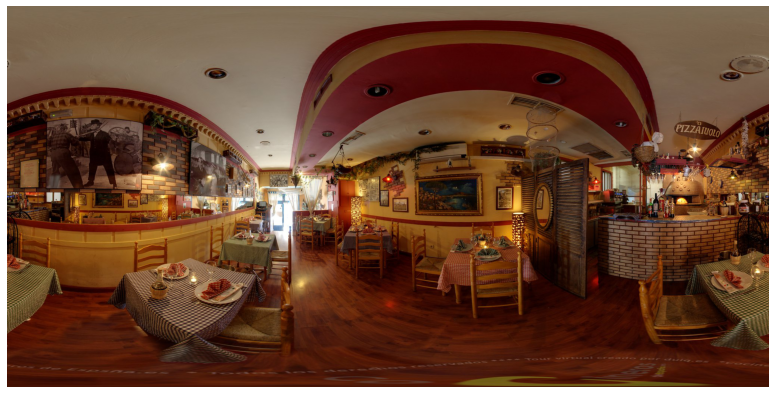

In [7]:
# checking
texture_image = textures.maps_padded()

plt.figure(figsize=(14,7))
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis('off');

In [8]:
mesh = Meshes(verts=[verts_list], faces=[faces_list], textures=textures)

## Setting Scene Parameters

In [17]:
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 0) 
cameras = OpenGLPerspectiveCameras(device=device, znear=0.5, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size = None,  # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

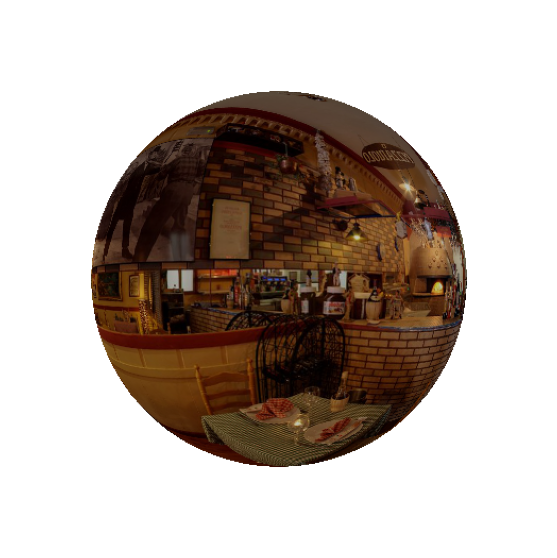

In [18]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

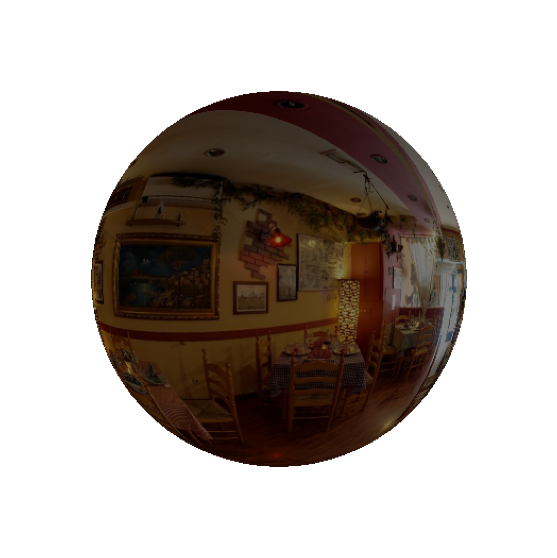

In [10]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

(-0.5, 511.5, 511.5, -0.5)

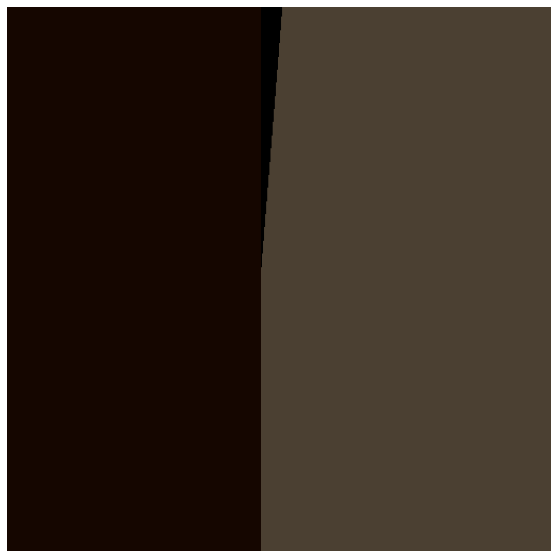

In [13]:
U = torch.tensor([[0, 0, 0]])
images = renderer(
            mesh, 
            cameras=OpenGLPerspectiveCameras(device=device, znear=0.5, R=R, T=U)
)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")

tensor([[0.0000, 0.0000, 2.5000]])
tensor([[0.0000, 0.0000, 2.3000]])
tensor([[0.0000, 0.0000, 2.1000]])
tensor([[0.0000, 0.0000, 1.9000]])
tensor([[0.0000, 0.0000, 1.7000]])
tensor([[0.0000, 0.0000, 1.5000]])
tensor([[0.0000, 0.0000, 1.3000]])
tensor([[0.0000, 0.0000, 1.1000]])
tensor([[0.0000, 0.0000, 0.9000]])
tensor([[0.0000, 0.0000, 0.7000]])
tensor([[0.0000, 0.0000, 0.5000]])


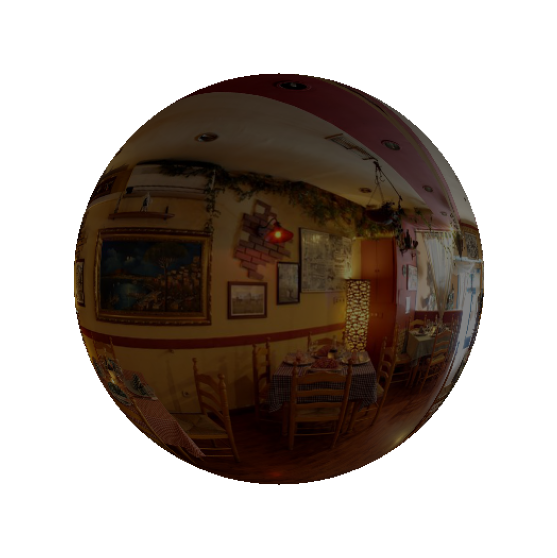

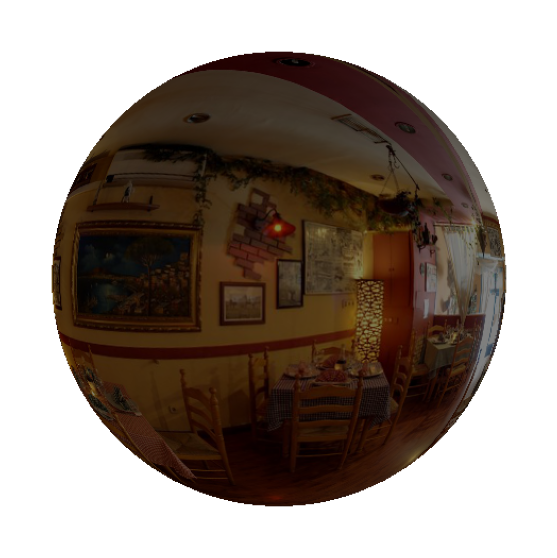

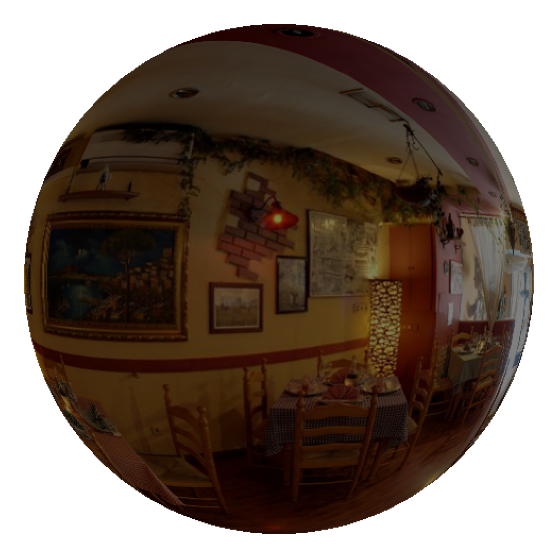

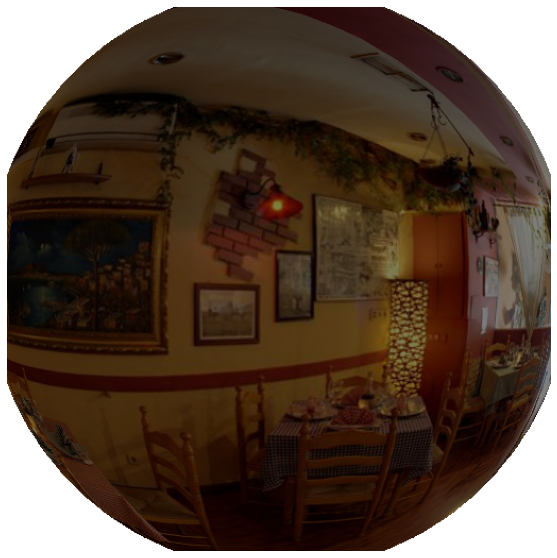

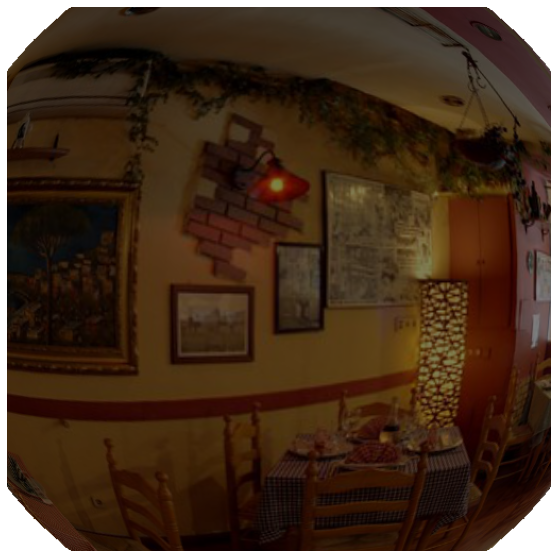

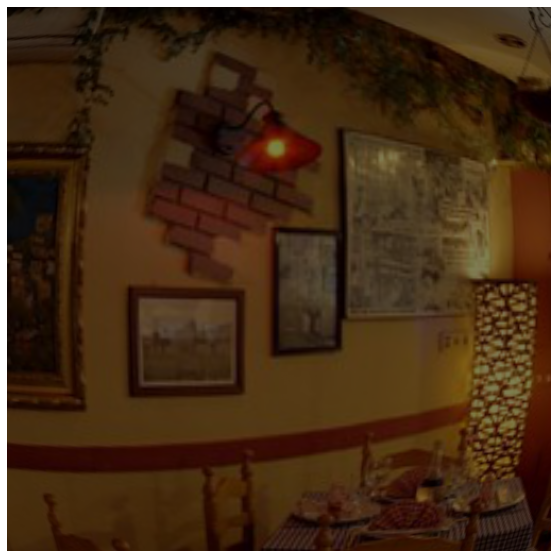

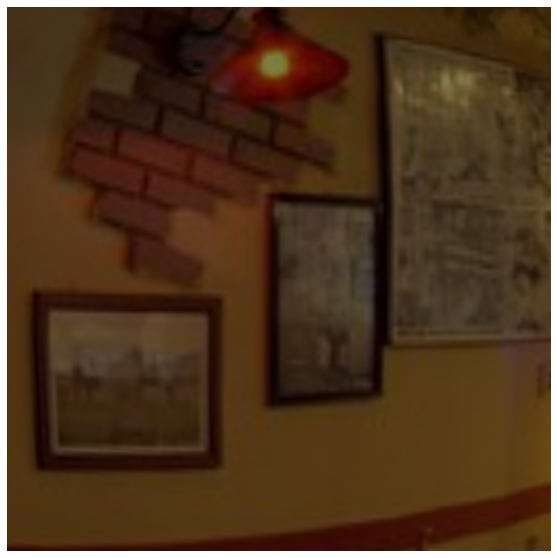

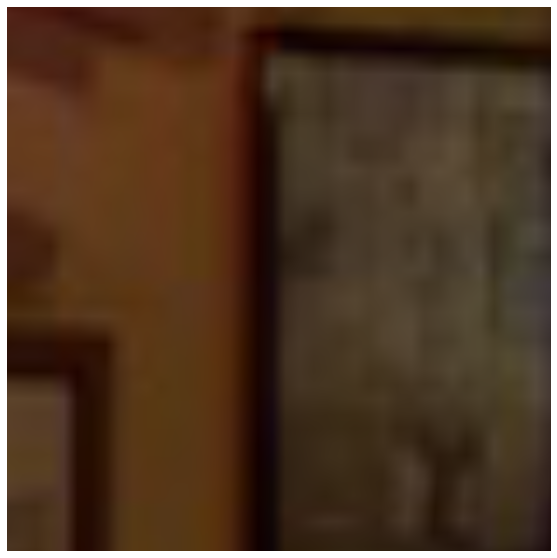

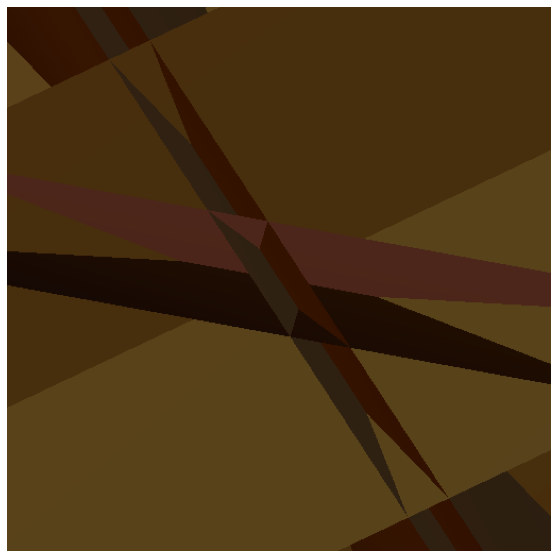

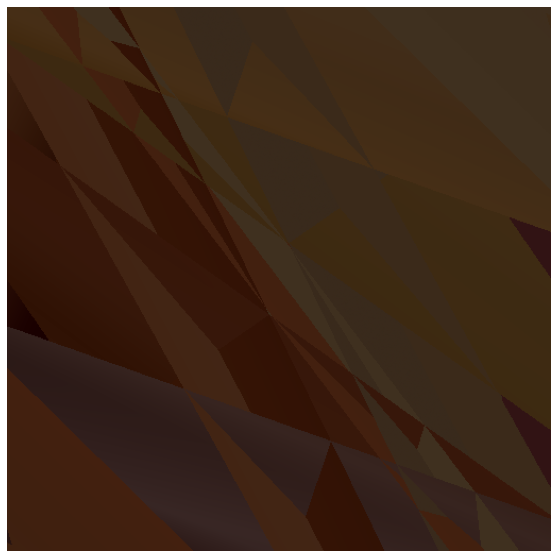

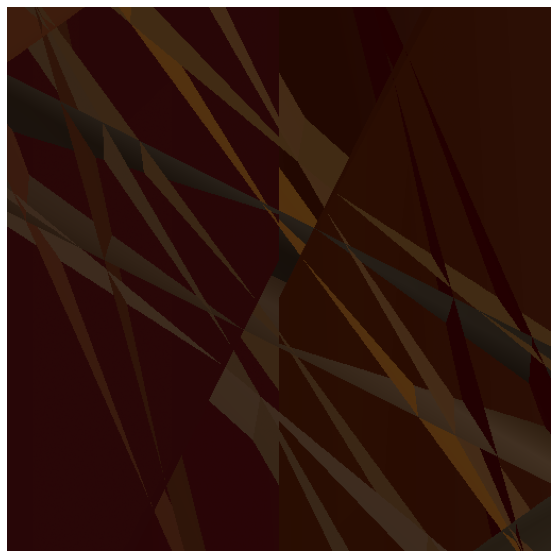

In [14]:
lights = PointLights(device=device, location=[[0.0, 0.0, 0.0]])
for i in range(1, 12):
    U = T + torch.tensor([[0, 0, -0.2*i]])
    images = renderer(mesh, 
                      cameras=OpenGLPerspectiveCameras(device=device, znear=0.5, R=R, T=U),
                     )
    print(U)
    plt.figure(figsize=(10, 10))
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.grid("off")
    plt.axis("off")

tensor([[0.0000, 0.0000, 2.4000]])
tensor([[0.0000, 0.0000, 2.1000]])
tensor([[0.0000, 0.0000, 1.8000]])
tensor([[0.0000, 0.0000, 1.5000]])
tensor([[0.0000, 0.0000, 1.2000]])
tensor([[0.0000, 0.0000, 0.9000]])
tensor([[0.0000, 0.0000, 0.6000]])
tensor([[0.0000, 0.0000, 0.3000]])
tensor([[0., 0., 0.]])
tensor([[ 0.0000,  0.0000, -0.3000]])
tensor([[ 0.0000,  0.0000, -0.6000]])


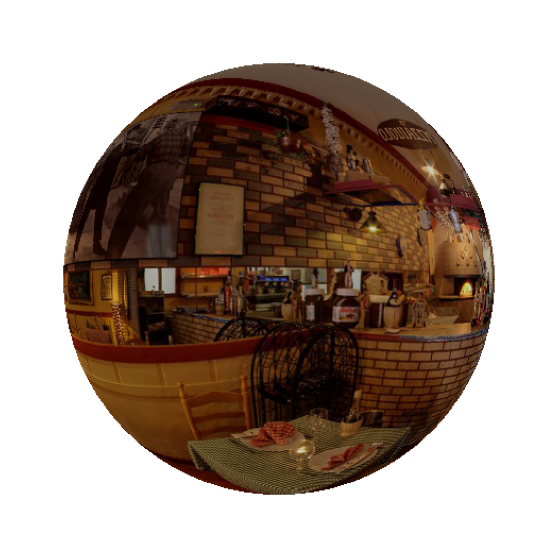

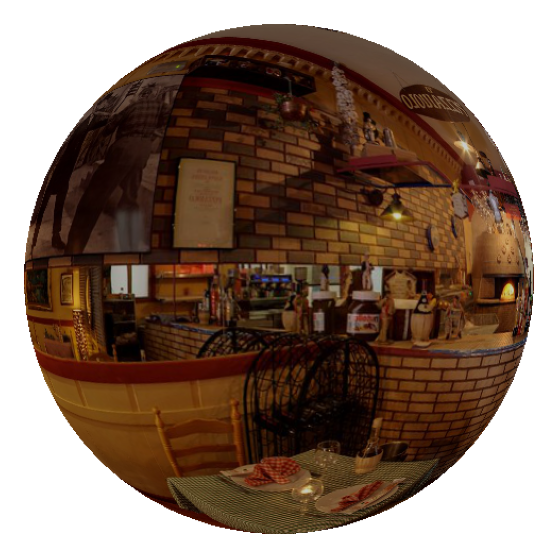

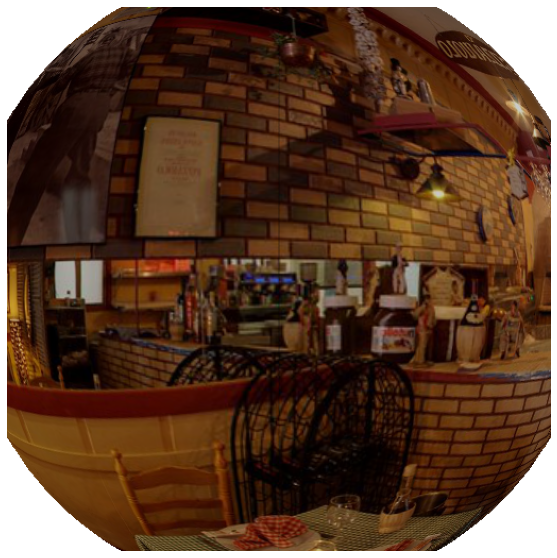

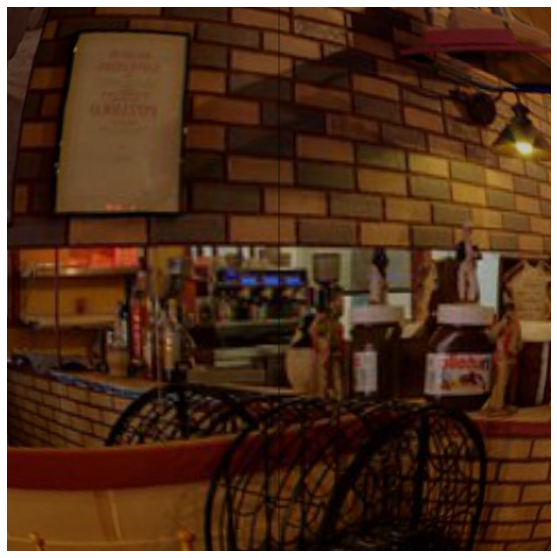

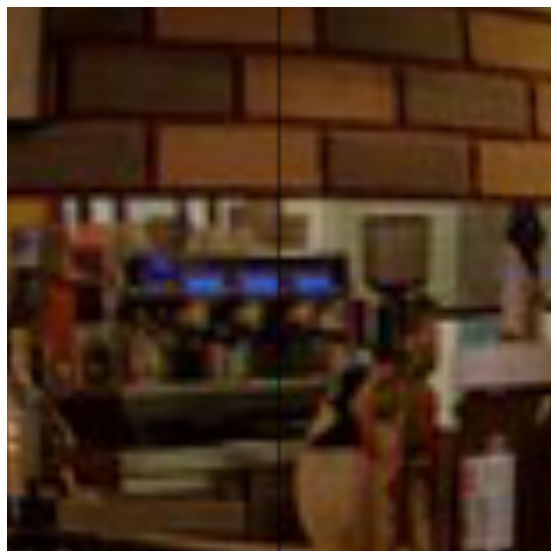

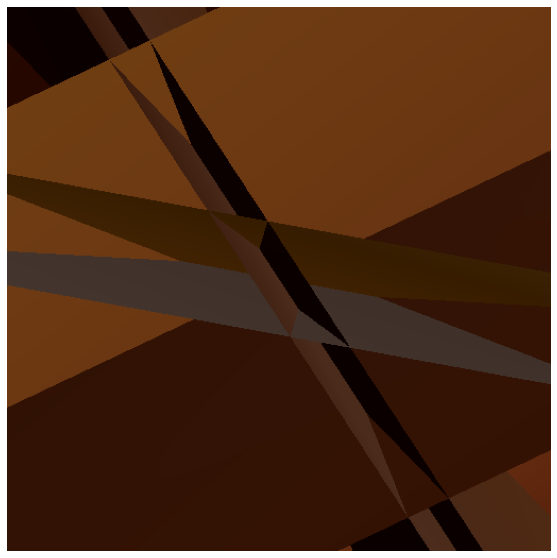

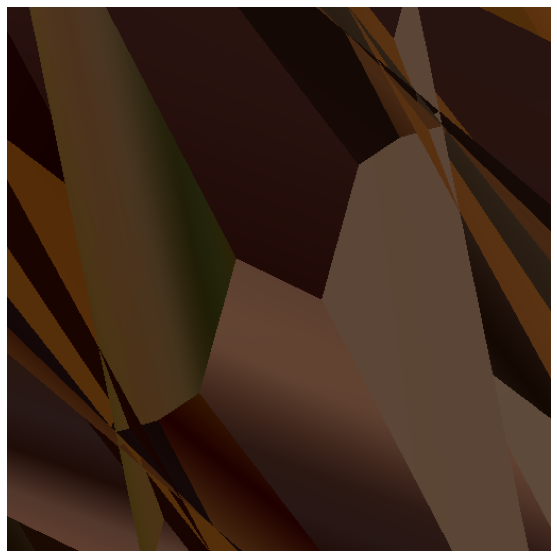

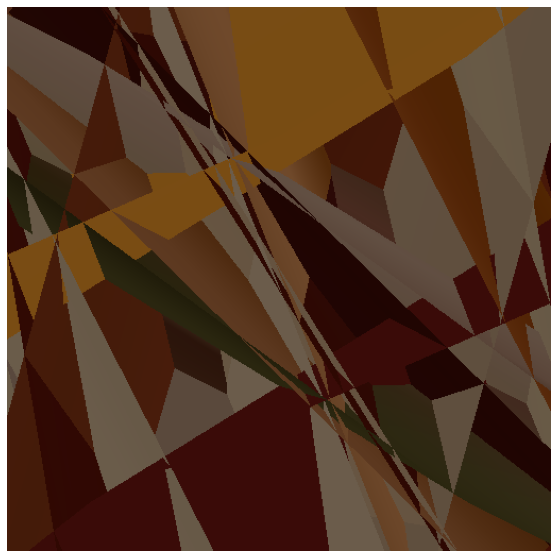

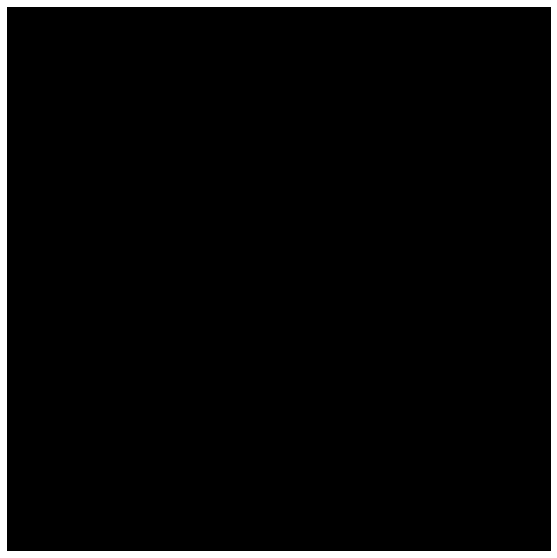

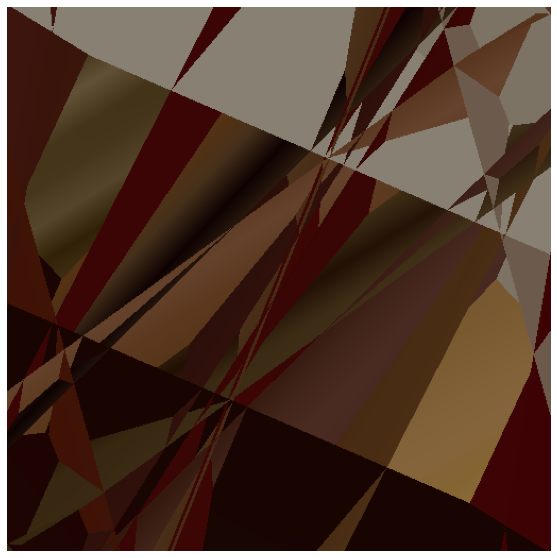

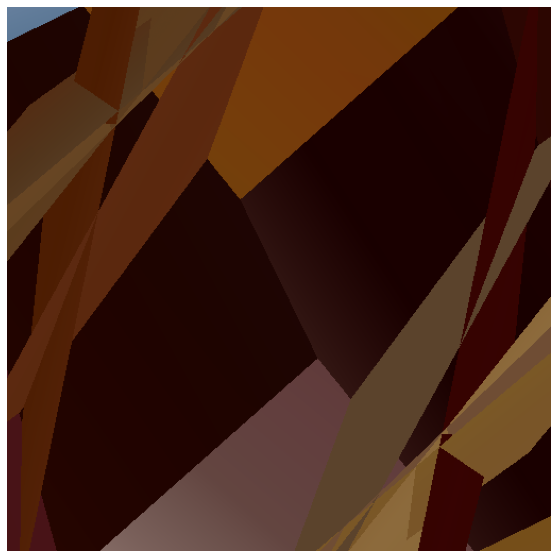

In [28]:
lights = PointLights(device=device, location=[[0.0, 0.0, 0.0]])
for i in range(1, 12):
    U = T + torch.tensor([[0, 0, -0.3*i]])
    images = renderer(
        mesh, 
        cameras=OpenGLPerspectiveCameras(device=device, znear=0.5, R=R, T=U),
        lights = lights
    )
    print(U)
    plt.figure(figsize=(10, 10))
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.grid("off")
    plt.axis("off")

In [29]:
# Rotate the object by increasing the elevation and azimuth angles
# R, T = look_at_view_transform(dist=0, elev=0, azim=0)
R2 = torch.eye(3).unsqueeze(0)
T2 = torch.tensor([0, 0, 0.1], dtype=torch.float32, device=device).unsqueeze(0)
cameras = OpenGLPerspectiveCameras(device=device, znear=1, R=R2, T=T2)


# Re render the mesh, passing in keyword arguments for the modified components.
lights = PointLights(device=device, location=[[0.0, 0.0, 0.0]])
images = renderer(mesh, cameras=cameras, lights=lights)

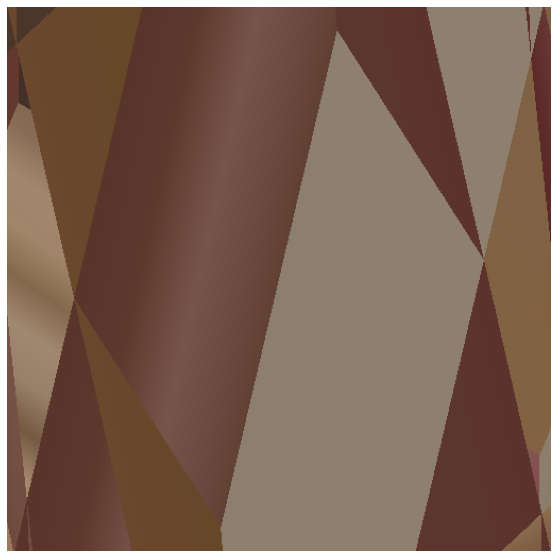

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");